## Financial Big Data Project : Impact of Louvain clustering on GMVP strategy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from data_cleaning import load_trade
from refreshTime import harmoniz_data,refresh_time,synchro_data,refresh_time_dask
from back_test import daily_back_testing,impor_data
import seaborn as sns

import dask
dask.config.set(scheduler="processes")

Date = pd.bdate_range('2010-01-01','2010-12-31')[1:] #We do not take the 1er January where there is no trades
Market_name = np.array(['AAPL.OQ','AMGN.OQ','AXP.N','BA.N','CAT.N','CSCO.OQ','CVX.N','DOW.N','GS.N','SPY.P','UTX.N','V.N','WMT.N'])

folder_path = 'D:/GitHub/ML_For_Finance/big data/data/data/'

#folder_path ='D:/GitHub/ML for Finance project/ML_For_Finance/big data/Data/data/'
#folder_path = '/Users/franckatteaka/Desktop/cours/Semester III/Financial big data/high freq data/'

In [5]:
len(Date)

260

In [9]:
i=260
i

260

In [7]:
temp= impor_data(Market_name,Date[i],folder_path)
t1=refresh_time_dask(temp,Date[i])
len(t1)

398

In [10]:
t2 = synchro_data(temp,Date[i])
t2

IndexError: index 260 is out of bounds for axis 0 with size 260

## Section 2 : Data Analysis

In [11]:
n=len(Date)
m=len(Market_name)
market_size = np.zeros((n,m))

for i in range(n):
    temp = impor_data(Market_name,Date[i],folder_path)
    for j in range(m):
        market_size[i,j]=len(temp[j])


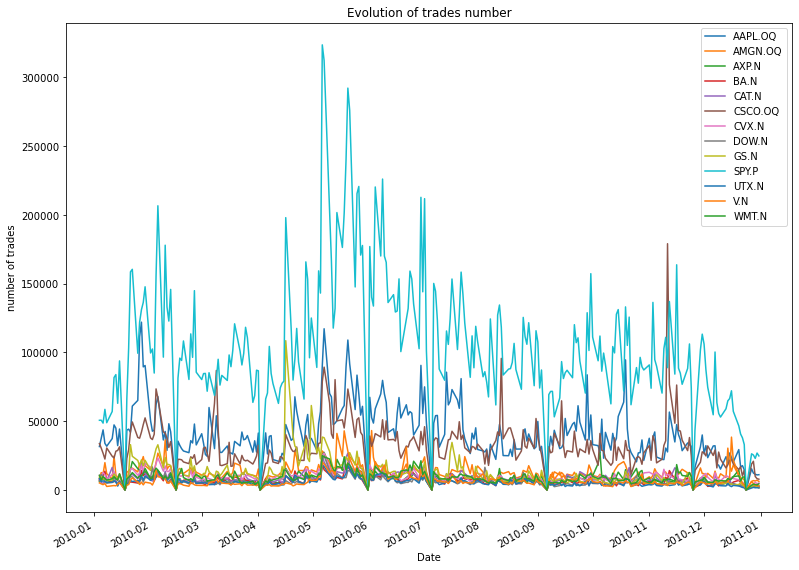

In [13]:
plt.figure(figsize=(13,10))
for j in range(m):
    plt.plot(Date,market_size[:,j],label=Market_name[j])
    
plt.legend()
plt.ylabel("number of trades")
plt.xlabel('Date')
plt.title('Evolution of trades number')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        
plt.gcf().autofmt_xdate()
plt.savefig('figures/number_trades.pdf')

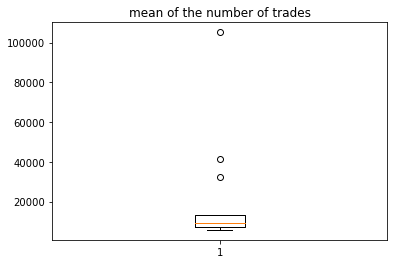

,mean trades
AAPL.OQ,41213.073077
AMGN.OQ,13022.373077
AXP.N,8417.542308
BA.N,6781.303846
CAT.N,8532.884615
CSCO.OQ,32440.665385
CVX.N,9982.492308
DOW.N,6068.430769
GS.N,12532.361538
SPY.P,105240.903846


In [22]:
mean_number = np.mean(market_size,axis=0)
plt.boxplot(mean_number)
plt.title('mean of the number of trades')
plt.savefig('figures/boxplot mean number of trades.pdf')
plt.show()
DF = pd.DataFrame(data=mean_number[np.newaxis,:].T,index=Market_name,columns=['mean trades'])
DF

In [23]:
num_0 =0
for i in range(n):
    if min(market_size[i])==0:
        num_0+=1
print('number of day where at least one market has 0 trades :',num_0)

number of day where at least one market has 0 trades : 8


## Section 3 : Data synchronisation

In [5]:
n=len(Date)
m=len(Market_name)
tau = np.zeros((n))

for i in range(n):
    temp1 = impor_data(Market_name,Date[i],folder_path)
    if min([len(df) for df in temp1])>0:
        temp2 = refresh_time_dask(temp1,Date[i])
        tau[i]=len(temp2)
    else :
        tau[i]=0

No handles with labels found to put in legend.


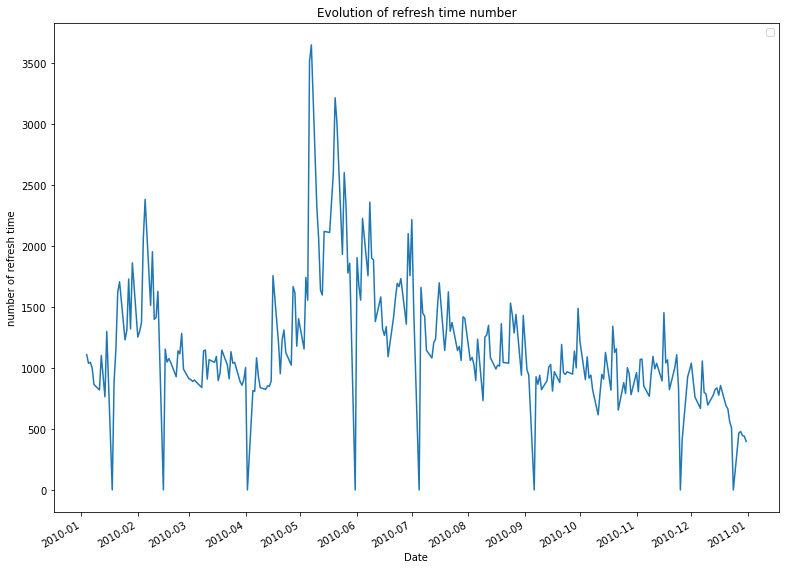

In [8]:
plt.figure(figsize=(13,10))

plt.plot(Date,tau)
    
plt.legend()
plt.ylabel("number of refresh time")
plt.xlabel('Date')
plt.title('Evolution of refresh time number')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        
plt.gcf().autofmt_xdate()
plt.savefig('figures/number_refresh_time.pdf')

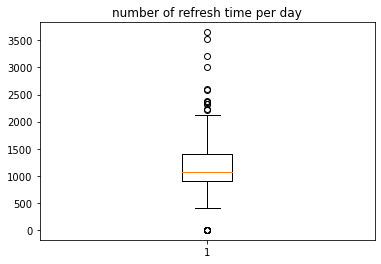

In [16]:
plt.boxplot(tau)
plt.title('number of refresh time per day')
plt.savefig('figures/boxplot number of refresh time per day.pdf')
plt.show()

In [17]:
print('mean of refresh time number :',np.mean(tau))
print('std of refresh time number :',np.std(tau))

mean of refresh time number : 1182.8153846153846
std of refresh time number : 527.7971169743072


In [18]:
tau_5 = tau[:-4]+tau[1:-3]+tau[2:-2]+tau[3:-1]+tau[4:]

In [20]:
print('mean of refresh time number on 5 business day:',np.mean(tau_5))
print('std of refresh time number on 5 business day:',np.std(tau_5))

mean of refresh time number on 5 business day: 5948.140625
std of refresh time number on 5 business day: 2160.212009395631


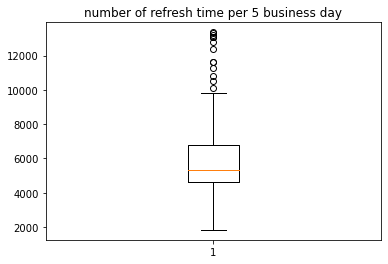

In [21]:
plt.boxplot(tau_5)
plt.title('number of refresh time per 5 business day')
plt.savefig('figures/boxplot number of refresh time per 5 business day.pdf')
plt.show()

In [ ]:
import time
n=len(Date)
m=len(Market_name)



def get_time(date):
    start_time = time.time()
    temp1 = impor_data(Market_name,date,folder_path)
    if min([len(df) for df in temp1])>0:
        temp2 = harmoniz_data(temp1)
        taui=len(temp2)
        T= time.time()-start_time
        ratio_Time_taui =T/taui
    else :
        T=time.time()-start_time
        ratio_Time_taui=0
    return np.array([T,ratio_Time_taui])
    
Time=[]


for i in range(n):
    a = get_time(Date[i])
    Time.append(a)
    



In [ ]:
plt.figure(figsize=(13,10))

plt.plot(day_test,Time)
    
plt.legend()
plt.ylabel("Time")
plt.xlabel('Date')
plt.title('Time computation to harmonize data')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        
plt.gcf().autofmt_xdate()
plt.savefig('figures/Time computation to harmonise data.pdf')

## Section 4 Louvain and GMVP performance

In [9]:
nday_init=0
nday_end=len(Date)-1
backtesting1=daily_back_testing(Market_name,folder_path,Date[nday_init:nday_init+5])
l=nday_end-nday_init-5
for i in range(nday_init+5,nday_end+1):
    backtesting1.daily_update(Date[i])
    print('avancement : %f '%((i-nday_init-5)/l))

avancement : 0.000000 
avancement : 0.003937 
avancement : 0.007874 
avancement : 0.011811 
avancement : 0.015748 
avancement : 0.019685 
avancement : 0.023622 
avancement : 0.027559 
avancement : 0.031496 
avancement : 0.035433 
avancement : 0.039370 
avancement : 0.043307 
avancement : 0.047244 
avancement : 0.051181 
avancement : 0.055118 
avancement : 0.059055 
avancement : 0.062992 
avancement : 0.066929 
avancement : 0.070866 
avancement : 0.074803 
avancement : 0.078740 
avancement : 0.082677 
avancement : 0.086614 
avancement : 0.090551 
avancement : 0.094488 
avancement : 0.098425 
avancement : 0.102362 
avancement : 0.106299 
avancement : 0.110236 
avancement : 0.114173 
avancement : 0.118110 
avancement : 0.122047 
avancement : 0.125984 
avancement : 0.129921 
avancement : 0.133858 
avancement : 0.137795 
avancement : 0.141732 
avancement : 0.145669 
avancement : 0.149606 
avancement : 0.153543 
avancement : 0.157480 
avancement : 0.161417 
avancement : 0.165354 
avancement 

ValueError: Shape of passed values is (441, 1), indices imply (442, 1)

In [10]:
Date[i]

Timestamp('2010-12-30 00:00:00', freq='B')

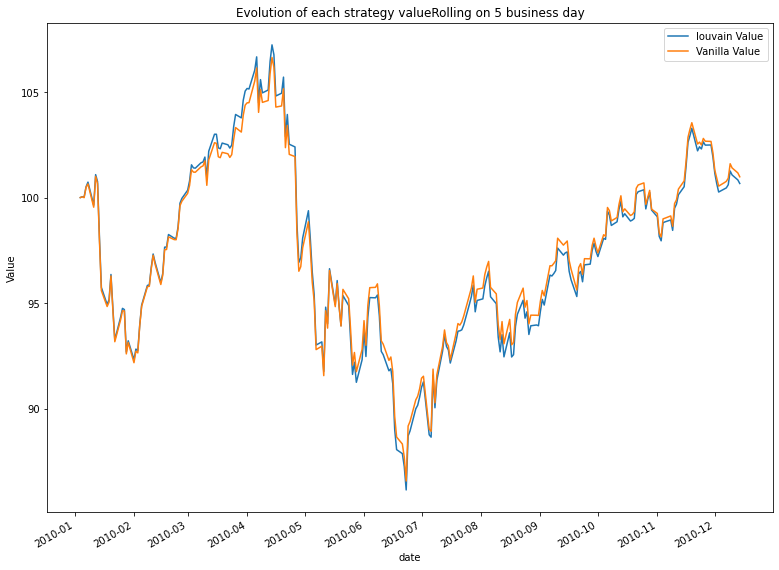

In [27]:
#backtesting1.plot_value('Rolling on 5 business day')
titre = 'Rolling on 5 business day'
plt.figure(figsize=(13,10))
        #we plot the value of each strategy
plt.plot(Date[:i-8-3],backtesting1.V_louvain,label='louvain Value')
        
plt.plot(Date[:i-8-3],backtesting1.V_vanilla,label='Vanilla Value')
plt.title('Evolution of each strategy value'+titre)
plt.legend()
plt.xlabel('date')
plt.ylabel('Value')
#we calibrate the x axis to print the day
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        
plt.gcf().autofmt_xdate()
plt.savefig('figures/Value_Strategies'+titre+'.pdf')
plt.show()

In [19]:
print(backtesting1.date_path)

None


No handles with labels found to put in legend.


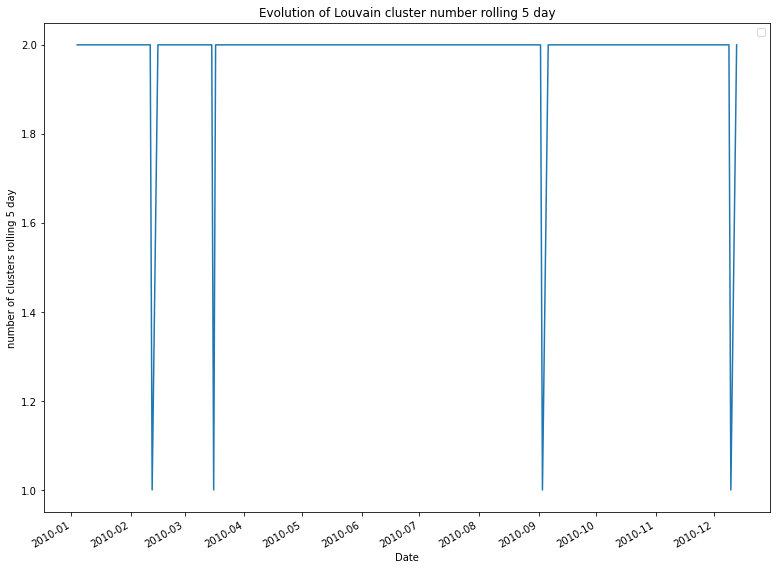

In [29]:
plt.figure(figsize=(13,10))

plt.plot(Date[:i-8-3-1],backtesting1.number_cluster)
    
plt.legend()
plt.ylabel("number of clusters rolling 5 day")
plt.xlabel('Date')
plt.title('Evolution of Louvain cluster number rolling 5 day')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        
plt.gcf().autofmt_xdate()
plt.savefig('figures/number_louvain_cluster rolling 5 day.pdf')

In [9]:
len(backtesting1.date_path)

136

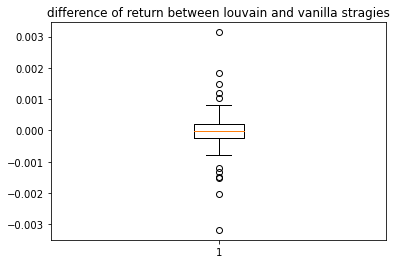

In [5]:
diff_return = np.array(backtesting1.louvain_return)-np.array(backtesting1.vanilla_return)
plt.boxplot(diff_return)
plt.title('difference of return between louvain and vanilla stragies')
plt.savefig('figures/boxplot difference between louvain and vanilla strategies.pdf')
plt.show()

In [6]:
n=len(backtesting1.louvain_return)
temp=[backtesting1.louvain_return[i]==backtesting1.vanilla_return[i] for i in range(n)]
print('number of time where the number of louvain cluster is 1 :', sum(temp))
print('rate of time where the number of louvain cluster is 1 :', sum(temp)/n)

number of time where the number of louvain cluster is 1 : 2
rate of time where the number of louvain cluster is 1 : 0.014814814814814815


In [7]:
print('std of louvain return : ',np.mean(backtesting1.louvain_return))
print('std of vanilla return : ',np.mean(backtesting1.vanilla_return))

std of louvain return :  -0.00048395096455186397
std of vanilla return :  -0.0004660340991797228


In [10]:
print('std of louvain return : ',np.std(backtesting1.louvain_return))
print('std of vanilla return : ',np.std(backtesting1.vanilla_return))

std of louvain return :  0.012143431804370318
std of vanilla return :  0.012208813549305173


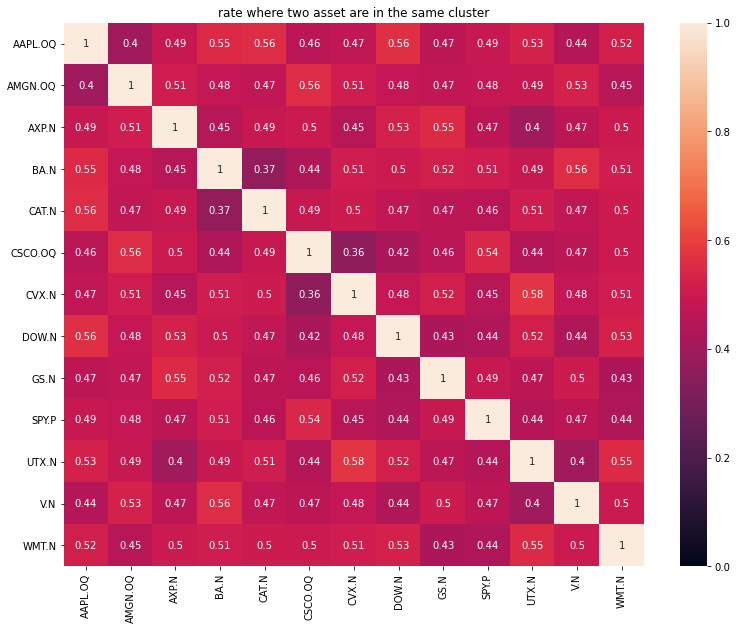

In [11]:
plt.figure(figsize=(13,10))
sns.heatmap(backtesting1.louvain_cluster/backtesting1.nombre_test,vmin=0, vmax=1,annot=True)
plt.title('rate where two asset are in the same cluster')
plt.savefig('figures/rate_two_assets_in_the_same_cluster.pdf')

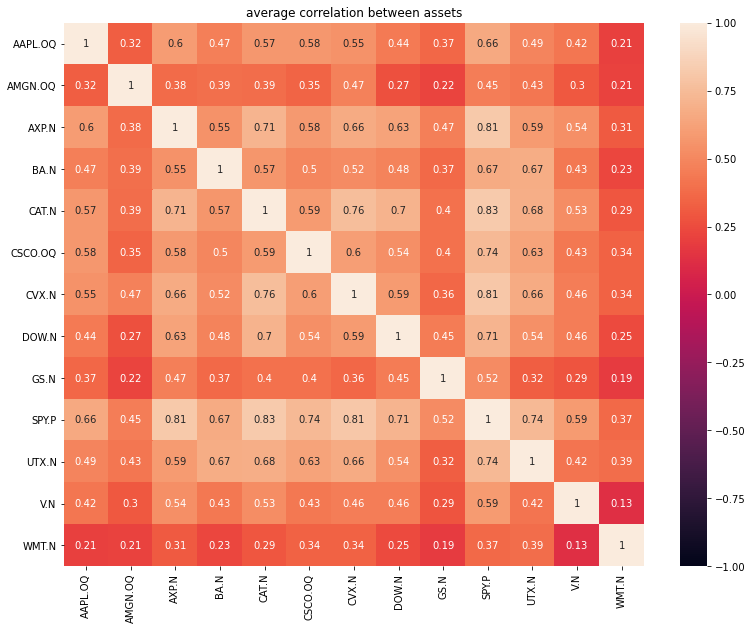

In [12]:
plt.figure(figsize=(13,10))
sns.heatmap(backtesting1.correlation/backtesting1.nombre_test,vmin=-1, vmax=1,annot=True)
plt.title('average correlation between assets')
plt.savefig('figures/correlation_heatmap.pdf')